In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [2]:
df = pd.read_csv('./data/audience.csv', low_memory=False)

In [3]:
consistent_data = df.iloc[:, :31]
numeric_data = consistent_data.iloc[:, 7:]

# df['Social network'].nunique()  # 3 distinct social networks
# df['Country'].value_counts(normalize=False).apply(np.log)  # LONG TAIL
# df['City'].value_counts(normalize=False).apply(np.log)  # LONG TAIL
# df['Birthdate'].describe()  # VERY FEW BIRTHDAYS EXIST

In [4]:
consistent_data.drop('Birthdate', axis=1).to_csv('./data/audience_numeric.csv', index=None)

In [5]:
# ensure than any weird data values below zero are removed
x = numeric_data.min()
for column in x[x<=0].index:
    numeric_data.loc[numeric_data[column] <= 0, column] = 1e-10

In [6]:
def get_boxcox_standardized(series):
    x, _ = stats.boxcox(series) 
    return (x - x.mean()) / x.std()

normalized_data = numeric_data.apply(get_boxcox_standardized)

<AxesSubplot:>

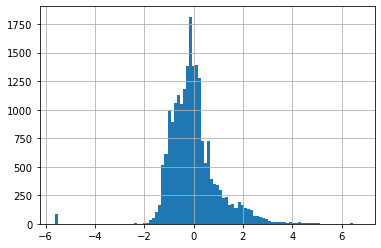

In [7]:
normalized_data['Followers'].hist(bins=100)

In [8]:
analysis = normalized_data.copy()

PCA Sucks

In [9]:
pca = PCA(0.9, whiten=True)

pca.fit(normalized_data)
embeddings = pca.transform(normalized_data)

pca.explained_variance_ratio_

array([0.61830013, 0.22362293, 0.05794258, 0.04979961])

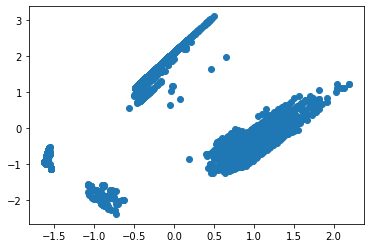

In [10]:
plt.scatter(embeddings[:, 0], embeddings[:, 1])

Let's try GMM approach

2
3
4
5
6
7


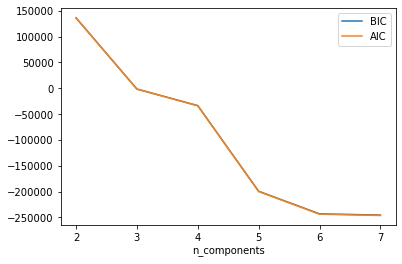

In [11]:
models = []
max_components = 8
n_components = np.arange(2, max_components)
for n in n_components:
    print(n)
    models.append(GaussianMixture(n, covariance_type='full', random_state=0).fit(embeddings))

plt.plot(n_components, [m.bic(embeddings) for m in models], label='BIC')
plt.plot(n_components, [m.aic(embeddings) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [12]:
best_model = models[-1]

In [13]:
probs = best_model.predict_proba(embeddings)
print(probs.round(3))

[[0.   0.   0.   ... 0.97 0.   0.  ]
 [0.   0.   0.   ... 1.   0.   0.  ]
 [0.   0.   0.   ... 1.   0.   0.  ]
 ...
 [0.   0.   1.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]]


Kmeans

In [14]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(normalized_data)

In [15]:
analysis['labels'] = kmeans.labels_
analysis['labels'].value_counts()

2    7126
0    5863
1    4765
3    2951
Name: labels, dtype: int64

In [16]:
SELECTED = 1
in_group = analysis[analysis['labels'] == SELECTED]
in_group.mean()

Followers                  -0.021219
Following                   0.365308
Posts                      -0.362313
Engagement                 -0.901739
Estimated reach            -1.696827
Estimated impressions      -1.717895
Avg. posts per week        -0.897256
Avg. posts per month       -0.897634
Avg. likes per post        -0.902041
Avg. engagement per post   -0.902213
Avg. comments per post     -0.876605
Avg. views per video       -0.546510
Cost per post (MIN)        -1.700589
Cost per post (MAX)        -1.702166
Post CPM (MIN)             -1.828956
Post CPM (MAX)             -1.828839
Post CPE (MIN)             -0.970898
Post CPE (MAX)             -0.970921
Cost per story (MIN)       -1.700967
Cost per story (MAX)       -1.699999
Story CPM (MIN)            -1.822049
Story CPM (MAX)            -1.817856
Story CPE (MIN)            -0.970384
Story CPE (MAX)            -0.969176
labels                      1.000000
dtype: float64

TSNE

In [17]:
from sklearn.manifold import TSNE
embeddings2 = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(embeddings)

/Users/blake/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


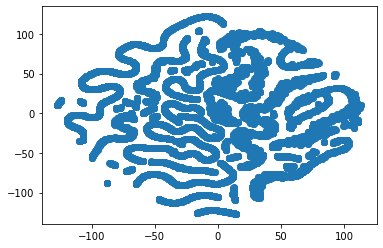

In [18]:
plt.scatter(embeddings2[:, 0], embeddings2[:, 1])

In [19]:
kmeans2 = KMeans(n_clusters=4, random_state=0).fit(embeddings2)

In [20]:
analysis['labels'] = kmeans2.labels_
analysis['labels'].value_counts()

1    5419
2    5343
3    5061
0    4882
Name: labels, dtype: int64